<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Pytorch to Fight Cancer

## Training an image classifier

We will do the following steps in order:

1. Load and normalize the dataset training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [2]:
!nvidia-smi

Wed May  1 18:19:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Setting: `/content` and `/content/datasets`

We save the root directory of the project '/content' as 'HOME' since we will be navigating through the directory to have multiple projects under the same HOME. Additionally, we will have the datasets in the 'dataset' directory, so all datasets are easily accessible for any project.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


Next, it imports the drive module from the google.colab library, which provides functionalities for mounting Google Drive in Google Colab.

Additionally, Google Drive is mounted in Google Colab and made available at the path /content/drive. The user will be prompted to authorize access to Google Drive. Once authorized, the content of Google Drive will be accessible from that point onwards in the Colab notebook.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. LOAD DATASET and DISPLAY.

Create the dataset directory (if it doesn't exist), where we are going to save the dataset with which we are going to train our CNN.

In [5]:
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


In [6]:
# Change to new datsets folder
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
!wget https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq exp0.zip

dataset_dir = /content/datasets
--2024-05-01 18:21:04--  https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/mlt797l5ab9rb6alndrw4/exp0.zip?rlkey=cqp4mwm053zwcoj7qzjfu4xjk [following]
--2024-05-01 18:21:05--  https://www.dropbox.com/scl/fi/mlt797l5ab9rb6alndrw4/exp0.zip?rlkey=cqp4mwm053zwcoj7qzjfu4xjk
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc66a51db35e61fa08095d9eff59.dl.dropboxusercontent.com/cd/0/inline/CSETj0lOXu30EDdPpOs4oN8ahptHdMxKpQLfvzYGtnbDndAu3n0YwuyjUGaFY_5IgqAsxCoO83jou9DP3-04W2bp3ImuLjUU6l3PgnCungEFgnbWRYqFX8bZy__ZI9v9K8Y/file# [following]
--2024-05-01 18:21:05--  https://uc66a51db35e61fa08095d9eff59.dl.dropboxusercontent.com/cd/0/inline/CSETj0lOXu30EDdPpOs4oN8a

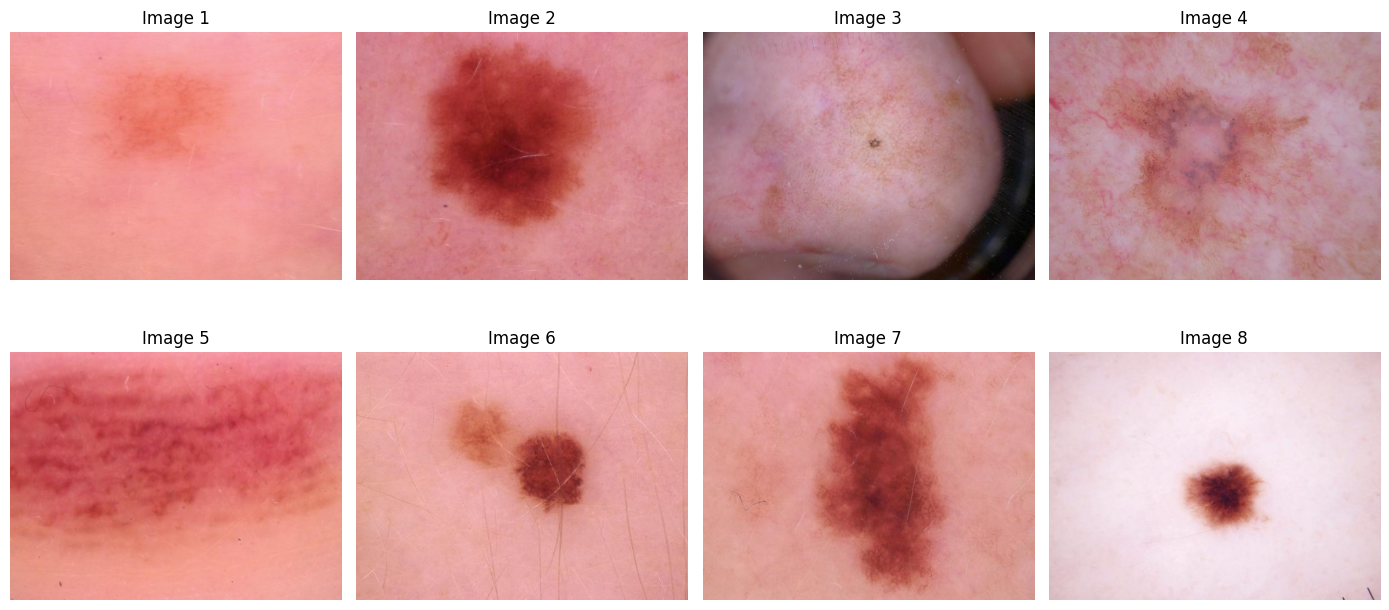

In [7]:
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_0/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()

In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar

In [10]:
#train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir   = "/content/datasets/exp0/val/"
test_dir  = "/content/datasets/exp0/test/"

train_set = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),transforms.RandomHorizontalFlip(),transforms.ToTensor()]))

val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),transforms.ToTensor()]))

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),transforms.ToTensor()]))

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_set.classes
print('   Classes: ', classes)



Length of Train Data :2700
Length of Validation Data : 300
Length of Test Data : 600
   Classes:  ['class_0', 'class_1']


Let us show one example for each class, for fun.

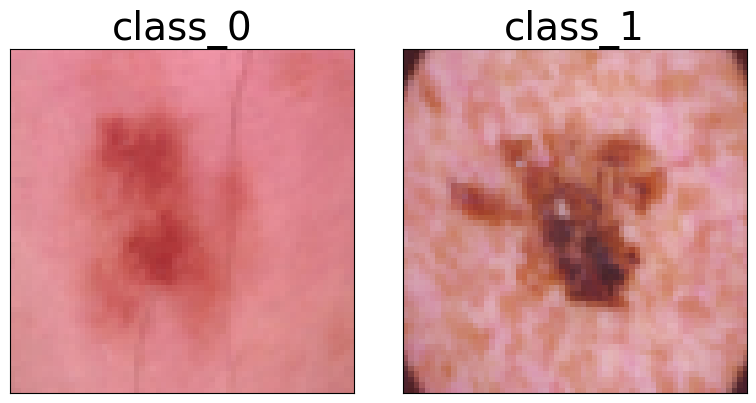

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*4,1*4), subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  ax.imshow(img.permute(1,2,0)) # for normalized channels

fig.tight_layout()

In [12]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 50
# epochs define the number of iterations
epochs = 10
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


In [13]:
# Create dataloaders object.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

Or we can display all images and its ground truth from a random batch.

In [14]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    for i in range(1, input+1):
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


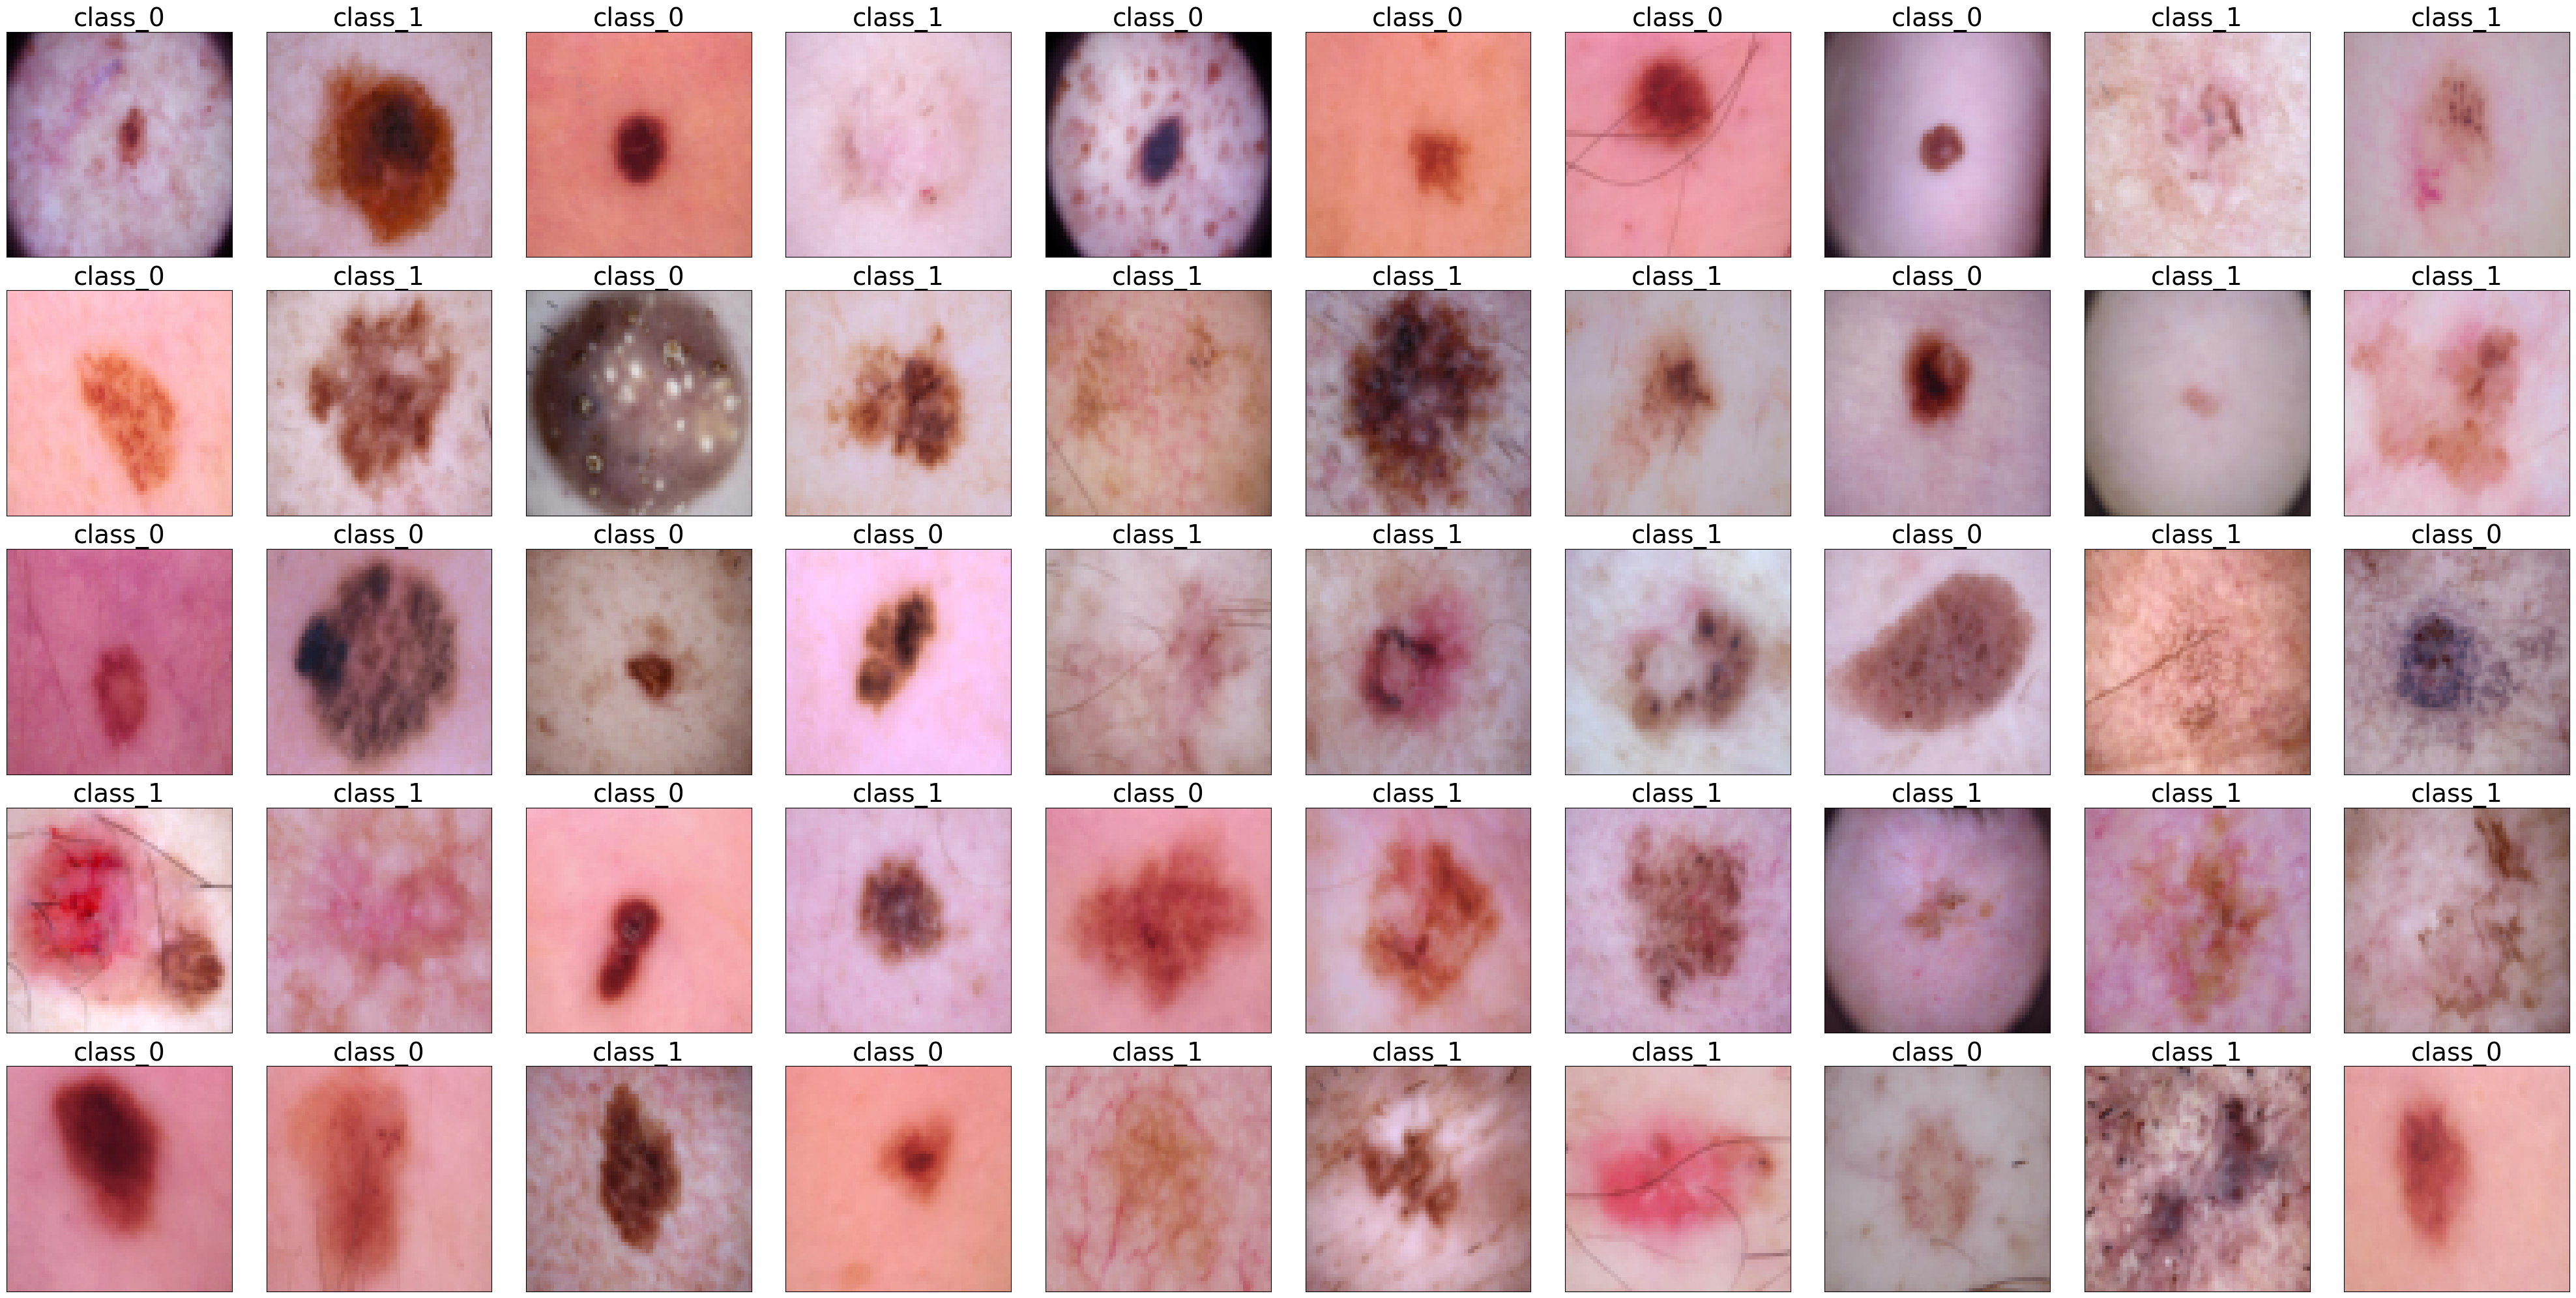

In [15]:
import itertools
import random

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4), subplot_kw={'facecolor': "#ebf5ff"})
rb_index = random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized

fig.tight_layout()


### 2. Define a Convolutional Neural Network


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    """
    VGG architecture definition.
    """

    def __init__(self, features: nn.Sequential, num_classes: int):
        super(VGG, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = make_layers([('L', 8192, 1024),
                                        ('L', 1024, num_classes)])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    """
    Función que crea las capas de la red neuronal a partir de una lista de configuración.
    """
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v[0] == 'M':
            layers += [nn.MaxPool2d(kernel_size=v[1], stride=v[2])]
        if v[0] == 'C':
            out_channels = v[1]
            if v[3] == 'same':
                padding = v[2]//2
            else:
                padding = 0
            conv2d = nn.Conv2d(in_channels, out_channels,
                               kernel_size=v[2], padding=padding, bias=False)
            non_linearity_activation = nn.ReLU()
            layers += [conv2d, non_linearity_activation]
            in_channels = out_channels
            layers[-2].name = 'Conv'+str(i)+'_'
        if v[0] == 'L':
            linear = nn.Linear(
                in_features=v[1], out_features=v[2], bias=False)
            if i < len(cfg)-1:
                non_linearity_activation = nn.ReLU()
                layers += [linear, non_linearity_activation]
            else:
                layers += [linear]
            layers[-2].name = 'FC'+str(i)+'_'
    return nn.Sequential(*layers)


cfg_list = {
    'vgg8': [('C', 128, 3, 'same', 2.0),
             ('C', 128, 3, 'same', 16.0),
             ('M', 2, 2),
             ('C', 256, 3, 'same', 16.0),
             ('C', 256, 3, 'same', 16.0),
             ('M', 2, 2),
             ('C', 512, 3, 'same', 16.0),
             ('C', 512, 3, 'same', 32.0),
             ('M', 2, 2)]
}


def vgg8(pretrained=None):
    cfg = cfg_list['vgg8']
    layers = make_layers(cfg)
    model = VGG(layers, num_classes=num_classes)
    if pretrained is not None:
        model.load_state_dict(torch.load(pretrained))
    return model

In [ ]:
# Large Model
class CNN_Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(16384,128), #1024
            nn.ReLU(),
            nn.Linear(128, 64), #512
            nn.ReLU(),
            nn.Linear(64,2) #6
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = CNN_Classification().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)


Using cpu device
CNN_Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    

In [ ]:
from torchsummary import summary

summary(model, (3,64,64)) # input = [3,64,64]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
from torchviz import make_dot

# Creamos un tensor de entrada
x = torch.randn(1, 3, 64, 64, device=device)

# Obtenemos la salida de la red neuronal
y = model(x)

# Visualizamos el grafo de cálculo de la red neuronal
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render(filename='myVGG8', format='png')

'myVGG8.png'

### 3. Define a Loss function and optimizer
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html). Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [ ]:
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )

### 4. Train the network


In [ ]:
print (len(train_dataloader.dataset)) #number of images from dataset
print (len(train_dataloader)) # number of images/batch_size (or number of batches)

2700
54


In [ ]:
def test(dataloader, model, criterion):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += criterion(preds, y).item()
      correct += (preds.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")

  return test_loss, correct

In [ ]:
def train(dataloader, model, criterion, optimizer):
  running_loss, correct, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  loop = tqdm(train_dataloader) # progressive bar
  model.train()
  for batch, (X, y) in enumerate(loop):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    preds = model(X)
    loss = criterion(preds, y)

    # Backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()
    optimizer.step()        # Does the update

    # print statistics

    # 1. loss.item() contains the loss of entire mini-batch,
    # but divided by the batch size
    running_loss += loss.item() #

    current += len(X) # current image (last image in the batch)

    correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    training_loss = running_loss/(batch+1)

    training_accuracy = correct/current

    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')

    loop.set_postfix(Training_Loss = training_loss, Accuracy = 100*correct/current)

  return training_loss, training_accuracy

In [ ]:
loss_train_history = []
accuracy_train_history = []
loss_test_history = []
accuracy_test_history = []
for epoch in range(epochs):
  #print(f"Epoch {epoch+1}\n-------------------------------")
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)
  loss_test,acc_test= test(val_dataloader, model, criterion)
  loss_test_history.append(loss_test)
  accuracy_test_history.append(acc_test)
print("Done!. Finished Training")

  0%|          | 0/54 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  0%|          | 0/54 [00:06<?, ?it/s]


ValueError: Target size (torch.Size([50])) must be the same as input size (torch.Size([50, 2]))

In [ ]:
for epoch in range(epochs):
    # Entrenamiento
    model.train()
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        # Ajustar las etiquetas para que tengan la misma forma que las salidas del modelo
        target = target.unsqueeze(1)  # Añadir dimensión adicional para que tenga la forma (batch_size, 1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Evaluación en datos de prueba
    model.eval()
    for data, target in val_dataloader:
        output = model(data)
        target = target.unsqueeze(1)  # Añadir dimensión adicional para que tenga la forma (batch_size, 1)
        loss_test, acc_test = test(output, target, criterion)
        loss_test_history.append(loss_test)
        accuracy_test_history.append(acc_test)

    # Guardar métricas de entrenamiento
    loss_train_history.append(loss_train)
    accuracy_train_history.append(acc_train)

print("Done!. Finished Training")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: result type Float can't be cast to the desired output type Long